In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import re
import joblib
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [4]:
df = pd.read_csv("dataset.csv",encoding='latin-1',header=None)

In [5]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
columns=['target','ids','date','flag','user','text']
df.columns=columns

In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.target.replace({0:'Negative',2:'Neutral',4:'Positive'},inplace=True)

In [9]:
df.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

In [11]:
corpus=[]
for i in range(0,len(df)):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',df['text'][i])
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    review=' '.join(review)
    corpus.append(review)

In [12]:
df.text=corpus

In [13]:
df.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,not behaving mad see


In [14]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df,test_size=0.20,random_state=123)

In [15]:
train_df.head()

,target,ids,date,flag,user,text
1578903,Positive,2189875205,Tue Jun 16 01:08:25 PDT 2009,NO_QUERY,silent_serenade,withholding information shae yup
51568,Negative,1679002293,Sat May 02 08:17:21 PDT 2009,NO_QUERY,tommytrc,uhhh ummmmm yes dear keep coming tweetups prom...
569210,Negative,2207868145,Wed Jun 17 08:29:12 PDT 2009,NO_QUERY,nikkikikicoco,amazing time wannqa come home come back suitca...
71896,Negative,1694083746,Mon May 04 01:00:43 PDT 2009,NO_QUERY,bszafko,ouch wrist hurts gym accident see surgeon
405089,Negative,2058584282,Sat Jun 06 15:13:45 PDT 2009,NO_QUERY,carolduff,going crazy work school


In [16]:
test_df.head()

,target,ids,date,flag,user,text
448282,Negative,2068921155,Sun Jun 07 14:56:42 PDT 2009,NO_QUERY,smiley_sophie,arm still hurts pulled yesterday
1475261,Positive,2065871668,Sun Jun 07 09:27:21 PDT 2009,NO_QUERY,ImmaChocoholic,much outside looking 4 years w energy totally ...
132529,Negative,1835774749,Mon May 18 06:43:27 PDT 2009,NO_QUERY,drmomentum,yes knew clusterfark way since right phd annou...
182348,Negative,1967121891,Fri May 29 19:00:46 PDT 2009,NO_QUERY,sweetsheilx,woke feel relieved haha go work 2 hours
907614,Positive,1695846172,Mon May 04 07:04:29 PDT 2009,NO_QUERY,monmariej,loving hot weather forecast rest week summer a...


In [17]:
documents = [text.split() for text in train_df.text]

In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [19]:
w2v_model.build_vocab(documents)

In [20]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30446


In [21]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(248024350, 279410310)

In [22]:
w2v_model.wv.most_similar("good")

[('great', 0.6862747669219971),
 ('goood', 0.5828567743301392),
 ('bad', 0.5508021116256714),
 ('gooood', 0.4927940368652344),
 ('nice', 0.4923568367958069),
 ('gooooood', 0.4912598133087158),
 ('gud', 0.4586310386657715),
 ('goooood', 0.45316165685653687),
 ('fantastic', 0.44524502754211426),
 ('rough', 0.4450629651546478)]

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.text)

In [24]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

290653

In [25]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=300)
X_train

array([[    0,     0,     0, ...,  3008, 21821,   796],
       [    0,     0,     0, ...,     7,   531,  2976],
       [    0,     0,     0, ...,  9856,   874,   109],
       ...,
       [    0,     0,     0, ...,   262,   774,     1],
       [    0,     0,     0, ...,   158, 17570,    11],
       [    0,     0,     0, ...,     7, 32054,     7]])

In [26]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=300)
X_test

array([[    0,     0,     0, ...,   256,  1664,   199],
       [    0,     0,     0, ...,  6190,  1790,    75],
       [    0,     0,     0, ...,  4779,   806,   111],
       ...,
       [    0,     0,     0, ...,   572, 66636,  1913],
       [    0,     0,     0, ...,   471,    82,   198],
       [    0,     0,     0, ...,   203,   337,  5137]])

In [27]:
y_train=train_df.target
y_train.head()

1578903    Positive
51568      Negative
569210     Negative
71896      Negative
405089     Negative
Name: target, dtype: object

In [28]:
y_test=test_df.target
y_test.head()

448282     Negative
1475261    Positive
132529     Negative
182348     Negative
907614     Positive
Name: target, dtype: object

In [29]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test=labelencoder.fit_transform(y_test)

In [30]:
y_train.shape

(1280000,)

In [31]:
y_test.shape

(320000,)

In [32]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290653, 300)


In [33]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [34]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87195900  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,356,401
Trainable params: 160,501
Non-trainable params: 87,195,900
_________________________________________________________________


In [35]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [38]:
model_history=model.fit(X_train, y_train,batch_size=1024,epochs=5,validation_split=0.1,verbose=1)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/5
1152000/1152000 [==============================] - 5419s 5ms/step - loss: 0.4898 - accuracy: 0.7603 - val_loss: 0.4517 - val_accuracy: 0.7863
Epoch 2/5
1152000/1152000 [==============================] - 5515s 5ms/step - loss: 0.4713 - accuracy: 0.7723 - val_loss: 0.4445 - val_accuracy: 0.7907
Epoch 3/5
1152000/1152000 [==============================] - 5526s 5ms/step - loss: 0.4646 - accuracy: 0.7766 - val_loss: 0.4404 - val_accuracy: 0.7932
Epoch 4/5
1152000/1152000 [==============================] - 5566s 5ms/step - loss: 0.4652 - accuracy: 0.7764 - val_loss: 0.4377 - val_accuracy: 0.7950
Epoch 5/5
1152000/1152000 [==============================] - 5571s 5ms/step - loss: 0.4602 - accuracy: 0.7796 - val_loss: 0.4360 - val_accuracy: 0.7960


In [39]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Exactitud (Accuracy)')

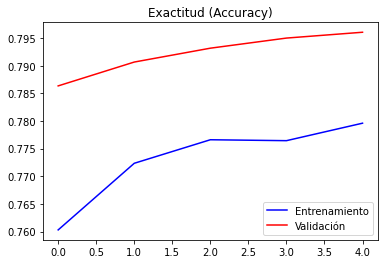

In [56]:
plt.plot(epochs,acc,label='Entrenamiento',color='blue')
plt.plot(epochs,val_acc,label='Validación',color='red')
plt.legend()
plt.title("Exactitud (Accuracy)")

Text(0.5, 1.0, 'Pérdida (Loss)')

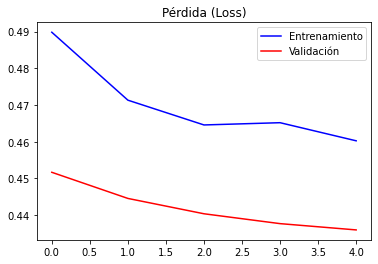

In [57]:
plt.plot(epochs,loss,label='Entrenamiento',color='blue')
plt.plot(epochs,val_loss,label='Validación',color='red')
plt.legend()
plt.title("Pérdida (Loss)")

In [42]:
def preprocess(text):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',text)
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    print(review)
    review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
    return review

In [66]:
def prediction(review):
    review=preprocess(review)
    score=model.predict(review)
    score=score[0]
    if score<0.4:
        print("Negative")
    elif score>0.4 and score<0.7:
        print("Neutral")
    else:
        print("Positive")
    print(score)

In [67]:
prediction("the food is not bad")

['food', 'not', 'bad']
Neutral
[0.4522917]


In [68]:
prediction("the film was horrible")

['film', 'horrible']
Negative
[0.05249749]


In [46]:
scores = model.predict(X_test, verbose=1, batch_size=1024)

320000/320000 [==============================] - 392s 1ms/step


In [47]:
scores

array([[0.00606215],
       [0.7476509 ],
       [0.7779515 ],
       ...,
       [0.98208714],
       [0.9246707 ],
       [0.97940886]], dtype=float32)

In [48]:
y_pred=np.where(scores>0.5,1,0)

In [49]:
y_pred

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [50]:
y_test

array([0, 1, 0, ..., 1, 1, 1])

In [51]:
cm=confusion_matrix(y_pred,y_test)
print(cm)

[[125846  31058]
 [ 34200 128896]]


In [52]:
print(accuracy_score(y_pred,y_test))

0.79606875


In [58]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

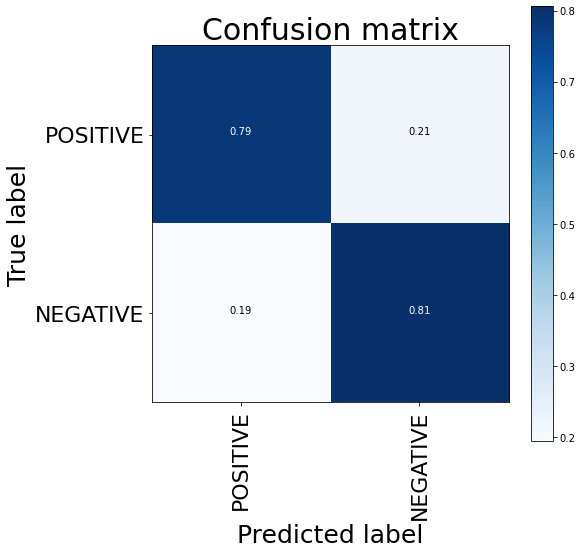

Wall time: 459 ms


In [64]:
%%time
import itertools
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['POSITIVE', 'NEGATIVE'], title="Confusion matrix")
plt.show()

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79    160046
           1       0.79      0.81      0.80    159954

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [65]:
print(accuracy_score(y_test, y_pred))

0.79606875


In [54]:
joblib.dump(w2v_model,'word2vec-2.pkl')
joblib.dump(tokenizer,'tokenizer-2.pkl')
joblib.dump(model,'final_model-2.pkl')

['final_model-2.pkl']